In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tsla = yf.Ticker("TSLA")

In [3]:
tsla.sustainability

,Value
2021-3,
palmOil,False
controversialWeapons,False
gambling,False
socialScore,17.31
nuclear,False
furLeather,False
alcoholic,False
gmo,False
catholic,False


In [4]:
stock_df = tsla.history(period='1y', start='2019-01-01', end=None)
stock_df.shape

(572, 7)

In [5]:
stock_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,61.220001,63.026001,59.759998,62.023998,58293000,0,0.0
2019-01-03,61.400002,61.880001,59.476002,60.071999,34826000,0,0.0
2019-01-04,61.200001,63.599998,60.546001,63.537998,36970500,0,0.0
2019-01-07,64.344002,67.348000,63.549999,66.991997,37756000,0,0.0
2019-01-08,68.391998,68.802002,65.403999,67.070000,35042500,0,0.0
...,...,...,...,...,...,...,...
2021-04-05,707.710022,708.159973,684.700012,691.049988,41842800,0,0.0
2021-04-06,690.299988,696.549988,681.369995,691.619995,28271800,0,0.0
2021-04-07,687.000000,691.380005,667.840027,670.969971,26309400,0,0.0


In [6]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

# Data Prep

In [7]:
stock_df['RSI'] = computeRSI(stock_df.Close, 14)
stock_df['NextClose'] = stock_df.Close.shift(-1, fill_value=0)
stock_df = stock_df.fillna(0)

In [8]:
stock_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,NextClose
Date,,,,,,,,,
2021-04-05,707.710022,708.159973,684.700012,691.049988,41842800,0,0.0,52.640751,691.619995
2021-04-06,690.299988,696.549988,681.369995,691.619995,28271800,0,0.0,52.730514,670.969971
2021-04-07,687.000000,691.380005,667.840027,670.969971,26309400,0,0.0,49.099764,683.799988
2021-04-08,677.380005,689.549988,671.650024,683.799988,23924300,0,0.0,51.341499,677.020020
2021-04-09,677.770020,680.969971,669.429993,677.020020,21402600,0,0.0,50.086142,0.000000


# The Rest

In [9]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [10]:
X = stock_df[['Close', 'RSI']]
y = stock_df.NextClose

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

<BarContainer object of 143 artists>

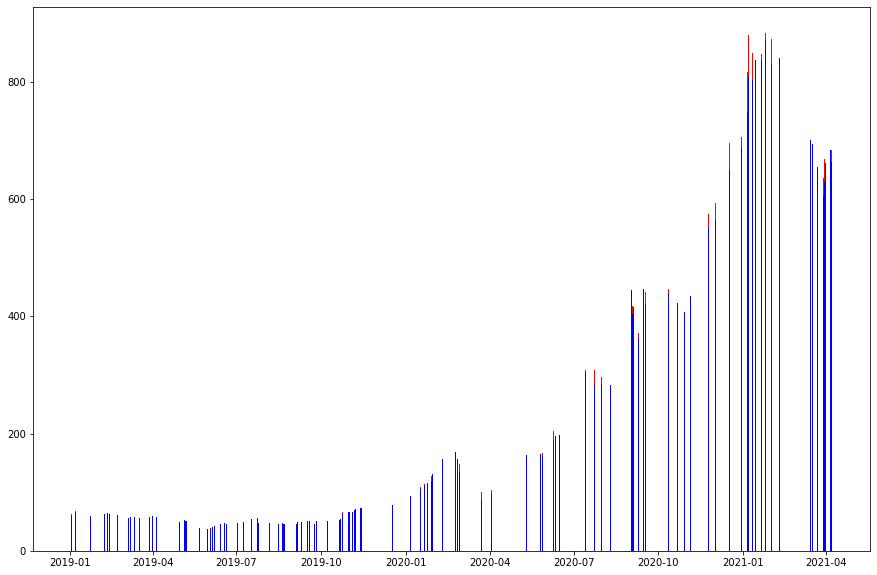

In [30]:
plt.figure(figsize=(15,10))
plt.bar(y_test.index, y_test, color = 'r')
plt.bar(y_test.index, y_pred, color = 'b')

In [14]:
print('r^2 error:', round(r2_score(y_test, y_pred), 3))
print('MAE:', round(mean_absolute_error(y_test, y_pred), 3))
print('Mean % Error:', round(mean_absolute_percentage_error(y_test, y_pred), 3))

r^2 error: 0.996
MAE: 8.886
Mean % Error: 0.04


In [15]:
stock_df_backtest = tsla.history(period='3mo', interval='1d', start='2018-01-01', end='2018-03-01')
stock_df_backtest['RSI'] = computeRSI(stock_df_backtest.Close, 14)
stock_df_backtest['NextClose'] = stock_df_backtest.Close.shift(-1)
stock_df_backtest = stock_df_backtest.fillna(0)[:-1]

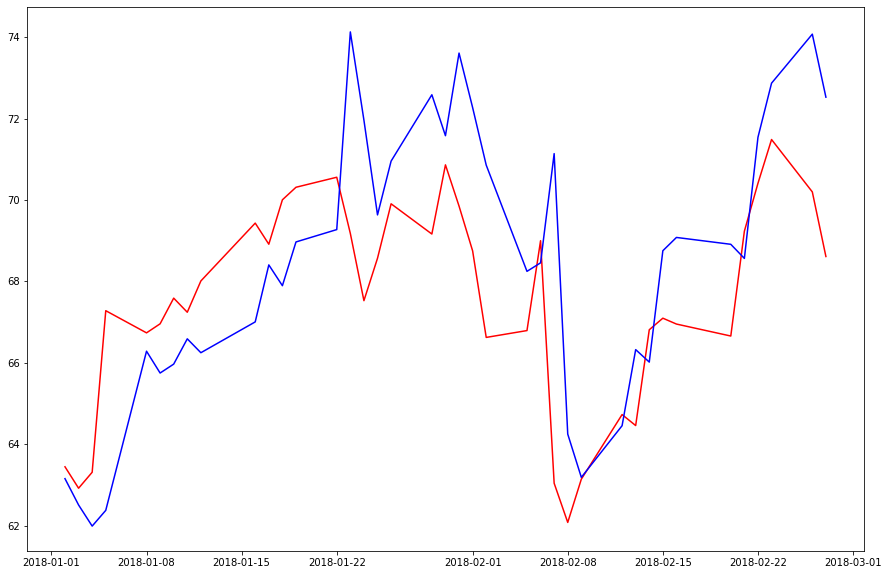

In [25]:
y_val = stock_df_backtest.NextClose
X_val = stock_df_backtest[['Close', 'RSI']]
y_val_pred = regr.predict(X_val)

plt.figure(figsize=(15,10))
plt.plot(y_val.index, y_val, color = 'r')
plt.plot(y_val.index, y_val_pred, color = 'b')

In [17]:
print('r^2 error:', round(r2_score(y_val, y_val_pred), 3))
print('MAE:', round(mean_absolute_error(y_val, y_val_pred), 3))
print('Mean % Error:', round(mean_absolute_percentage_error(y_val, y_val_pred), 3))

r^2 error: -0.13
MAE: 2.042
Mean % Error: 0.03


In [18]:
todays_history = tsla.history(period = '1d', interval='1d',start='2021-04-09', end='2021-04-10')
todays_history['RSI'] = computeRSI(todays_history.Close, 14)
todays_history = todays_history.fillna(0)
todays_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI
Date,,,,,,,,
2021-04-08,677.380005,689.549988,671.650024,683.799988,23924300,0,0,0.0
2021-04-09,677.770020,680.969971,669.429993,677.020020,21402600,0,0,0.0


In [19]:
prediction = regr.predict(todays_history[['Close', 'RSI']])

In [20]:
prediction

array([673.69556498, 667.01578342])

In [21]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [22]:
train, test = train_test_split(stock_df.Close, train_size=150)

In [23]:
# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
# x = np.arange(stock_df.Close.shape[0])

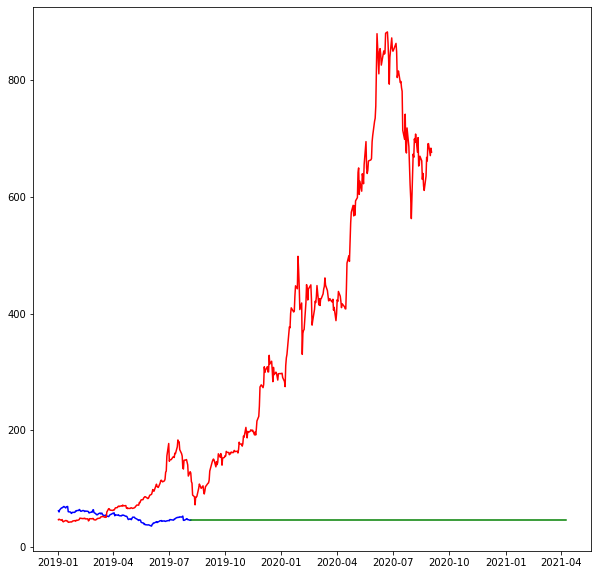

In [31]:
x = stock_df.index
plt.figure(figsize=(10,10))
plt.plot(x[:150], train, c='blue')
plt.plot(x[:len(test)], test, c='red')
plt.plot(x[150:], forecasts, c='green')
plt.show()

<AxesSubplot:xlabel='Date'>

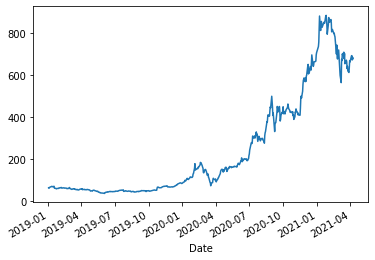

In [33]:
stock_df.Close.plot()